# More Classification, Metrics, and Class Imbalances

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
toy=pd.read_csv('toy_imb.csv')
toy.head()

,A,B,C,D,E,Target
0,-0.138680,0.537996,0.030868,-0.749413,-1.255079,0
1,1.153143,0.909027,-0.866711,-1.727731,-0.579336,0
2,1.609316,-1.935142,0.861705,0.349423,-1.135398,0
3,1.176314,1.524320,-0.137904,0.816670,0.663997,0
4,-0.245852,-0.158138,1.167393,-1.378489,0.679757,0


Like MakeHastie but with a higher value so that fewer observations end up in positive class.

In [4]:
#def target(row):
#    if row['A']**2+row['B']**2+row['C']**2+row['D']**2+row['E']**2>9:
#        return 1
#    else:
#        return 0
#toy['Target']=toy.apply(target,axis=1)
#toy.to_csv('toy_imb.csv',index=0)

In [5]:
len(toy)

1000

In [6]:
toy['Target'].sum()/len(toy)

0.117

This dataset has a significant class imbalance. The positive class (1) is only around 11% of the observation. This presents a challenge in identifying a good classifier. 

<AxesSubplot:>

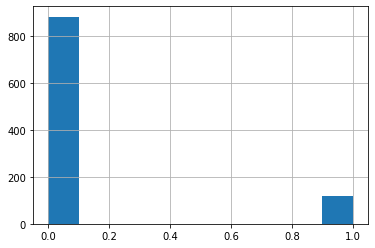

In [7]:
toy.Target.hist()

In [8]:
X=toy.drop('Target',axis=1)
y=toy['Target']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=5)

In [10]:
print(sum(y_train)/len(y_train),":",sum(y_test)/len(y_test))

0.11571428571428571 : 0.12


## Let's try a few classifiers

In [11]:
logreg=LogisticRegression().fit(X_train,y_train)

Note: Some folks have been getting a convergence error in their logistic regression models in sklearn: If so a good idea is to scale the data using ```StandardScaler```

In [12]:
logreg.score(X_test,y_test)

0.88

In [13]:
from sklearn.dummy import DummyClassifier

In [14]:
dum_maj=DummyClassifier(strategy='most_frequent').fit(X_train,y_train)

In [15]:
dum_maj.score(X_test,y_test)

0.88

So Logistic Regression and Dummy Classifier have 88% accuracy. How do we feel about that?

Let's also build a simple depth 4 decision tree classifier:

In [16]:
Tclf = DecisionTreeClassifier(max_depth=4,random_state=0).fit(X_train,y_train)

In [17]:
Tclf.score(X_test,y_test)

0.89

Confusion matrix (cross-tabulated True vs Predicted) for the **Logistic Regression Classifier**:

In [18]:
pd.crosstab(y_test,logreg.predict(X_test))

col_0,0
Target,
0,264
1,36


Confusion matrix for the **Dummy Classifier**:

In [19]:
pd.crosstab(y_test,dum_maj.predict(X_test))

col_0,0
Target,
0,264
1,36


Confusion matrix for the **Tree Classifier**:

In [20]:
pd.crosstab(y_test,Tclf.predict(X_test))

col_0,0,1
Target,,
0,261,3
1,30,6


So, the Logistic Regression classifier and the dummy classifier are just predicting 0 for all classes. The tree classifier seems like it represents small porogress, so...

Let's try a random forest classifier:

In [21]:
rf = RandomForestClassifier(n_estimators=400,max_features='sqrt',random_state=0).fit(X_train,y_train)

In [22]:
accuracy_score(rf.predict(X_test),y_test)

0.9166666666666666

Confusion Matrix for the **Random Forest Classifier**:

In [23]:
pd.crosstab(y_test,rf.predict(X_test))

col_0,0,1
Target,,
0,257,7
1,18,18


Can add row and column labels for readability:

In [24]:
pd.crosstab(y_test,rf.predict(X_test),rownames=['True'], colnames=['Predicted'])

Predicted,0,1
True,,
0,257,7
1,18,18


The tree based methods are at least predicting some 1 classes.

Let's consider the cells in the cross tabulation of Actual Labels versus Model Predictions. Think of Class 1 as **POSITIVE** and Class 0 as **NEGATIVE**.

 \\\  | Predicted 0 | Predicted 1
---:|:---:| ---
**Actual 0** | $TN$ | $FP$
**Actual 1** | $FN$ | $TP$

(from our model perspective:)

* $TN$ = True Negative
* $TP$ = True Positive
* $FN$ = False Negative
* $FP$ = False Positive

Thus far we've been using accuracy to assess classifiers. Accuracy is correct predictions over total observations:

$$
\text{Accuracy} = \frac{TN+TP}{TN+FN+FP+TP}
$$

In the test set above there are 300 observations:

In [25]:
len(y_test)

300

In [26]:
sum(y_test)

36

In [27]:
sum(y_test)/len(y_test)

0.12

Only 12% are in Class 1. We can get a seemingly (misleadingly) "*accurate*" classifier by just predicting 0 all the time. Accuracy is 88%.

Obviously, this is a useless classifier. Accuracy is a metric that works well when the classes are roughly balanced but fails to help us evaluate a classifier in the face of imbalanced data.

We need alternative metrics to accuracy to see how/what the classifier is doing. Two important metrics are: ***Precision*** and ***Recall***.

### Precision: What fraction of our *predicted* 1s are *actually* 1s? 

$$
\text{Precision} = \frac{TP}{TP+FP}
$$

### Recall: What fraction of the *actual* 1s do we catch?

$$
\text{Recall}=\frac{TP}{TP+FN}
$$

High Precision: Good if we want to limit $FP$. If you get an automated notification that you tested +, we might not want to tell a lot of people who don't have the disease that they have it. OR: We work for a pharmaceutical company and we are going to run a clinical trial (experiment). It's expensive! We want to be sure the drug in fact works when we say it works. We want to limit the number of false positives: we say it works but it doesn't. 

High Recall: Good metric if we want to limit $FN$. Example: Disease diagnosis. A $FN$ here mean that we are predicting "No Disease" when, in fact, the disease is present. This has obvious negative consequences for the patient. 

Covid antibody test: 1 means ANTIBODIES PRESENT:
* FP = we say you have antibodies but you dont.
* FN = We say you don't have antibodies but you do.

* Precision: fraction of people we claim to have antibodies who actually do.
* Recall: fraction of people truly having antibodies that we say have them.

 There's a new blood test that screens for several cancers using cell-free DNA and does not require FDA approval. Cost is around $1000. 

* FP : Test says Cancer but patient really does not have cancer.
* FN : Test says NO Cancer but patrient really *does* haver cancer.

Trade off: The more you tune up the tests ability to detect the disease (reduce the FNs) you will increase the number of FPs.

Aside: Suppose a test
* gives a correct + result 99% of time 
* gives a correct - result 99% of time 
* The disease has a 1% prevalence in the populaiton 

What is the probability that a person has the disease given a positive test result?

$$P(\text{Have} | +) = \frac{P(\text{Have and }+)}{(P(\text{Have and }+)+P(\text{Don't Have and }+)}$$

<img src="Bayes.png">

Precision: The fraction of True Positives out of all positive tests (True Pos + False Pos) 

In [28]:
#.01*(.99)/(.01*.99+.99*.01)
#image next commented out

<!--<img src="Comp.png">-->

In [29]:
from sklearn.metrics import classification_report

Back to evaluating the classifiers we built above.

Start with the tree classifier:

In [30]:
pd.crosstab(y_test,Tclf.predict(X_test),rownames=["True"],colnames=['Predicted'])

Predicted,0,1
True,,
0,261,3
1,30,6


In [31]:
print(classification_report(y_test,Tclf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       264
           1       0.67      0.17      0.27        36

    accuracy                           0.89       300
   macro avg       0.78      0.58      0.60       300
weighted avg       0.87      0.89      0.86       300



Precision (class 1): TP/(TP+FP); Recall (class 1): TP /(TP+FN)

In [32]:
print(np.round(6/(6+3),2),":",np.round(6/(6+30),2))

0.67 : 0.17


For the Random Forest:

In [33]:
print(classification_report(y_test,rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       264
           1       0.72      0.50      0.59        36

    accuracy                           0.92       300
   macro avg       0.83      0.74      0.77       300
weighted avg       0.91      0.92      0.91       300



For the logistic regression classifier:

In [34]:
pd.crosstab(y_test,logreg.predict(X_test),rownames=["True"],colnames=['Predicted'])

Predicted,0
True,
0,264
1,36


In [35]:
print(classification_report(y_test,logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       264
           1       0.00      0.00      0.00        36

    accuracy                           0.88       300
   macro avg       0.44      0.50      0.47       300
weighted avg       0.77      0.88      0.82       300



/home/hamstersnail/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hamstersnail/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hamstersnail/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Errors thrown because we are dividing by 0 : TP=FP=0

### F1 score

In [36]:
from sklearn.metrics import f1_score

In [37]:
f1_score(y_test,rf.predict(X_test))

0.5901639344262295

f1-score is an average of precision and recall (heavily influenced by the smaller of the two). 

f1 is the harmonic mean of P and R:
$$
\left(\frac{P^{-1}+R^{-1}}{2}\right)^{-1} = \frac{2PR}{P+R}
$$

(Why?) Aside: Suppose a car travels distance of 100 miles at 30 mph and 100 back at 70 mph. What's the average speed?

Not 50:

$$
\frac{distance}{time} = \frac{200}{\frac{100}{30}+\frac{100}{70}} =42
$$

$$
\frac{2d}{ \frac{d}{s_1} + \frac{d}{s_2} } = \frac{2}{\frac{1}{s_1}+\frac{1}{s_2}} = \left(\frac{s_1^{-1}+s_2^{-1}}{2}\right)^{-1}
$$

f1-score is between 0 and 1, but won't be high (close to 1) unless both precision and recall are high.

One last reminder: Remember that logistic regression predicts the probability of an observation belonging to class 1. We can use a threshold other than 0.5 to increase the number of class 1 predictions:

In [38]:
logreg.predict_proba(X_test)[0:10]

array([[0.85720527, 0.14279473],
       [0.89870153, 0.10129847],
       [0.92133599, 0.07866401],
       [0.83273605, 0.16726395],
       [0.91643961, 0.08356039],
       [0.88651245, 0.11348755],
       [0.85480562, 0.14519438],
       [0.86449747, 0.13550253],
       [0.83468391, 0.16531609],
       [0.89353077, 0.10646923]])

In [39]:
logreg.predict(X_test)[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
new_lr_pred = logreg.predict_proba(X_test)[:,1] >.2

In [41]:
f1_score(y_test,new_lr_pred)

0.2608695652173913

In [42]:
print(classification_report(y_test,new_lr_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       264
           1       0.60      0.17      0.26        36

    accuracy                           0.89       300
   macro avg       0.75      0.58      0.60       300
weighted avg       0.86      0.89      0.86       300



In [43]:
pd.crosstab(y_test,new_lr_pred,colnames=['Predicted'])

Predicted,False,True
Target,,
0,260,4
1,30,6


Actually, the random forest has a **predict probability** functionality too.

In [44]:
rf.predict_proba(X_test)[0:10]

array([[0.985 , 0.015 ],
       [0.9975, 0.0025],
       [0.9   , 0.1   ],
       [0.88  , 0.12  ],
       [0.9475, 0.0525],
       [1.    , 0.    ],
       [0.9375, 0.0625],
       [1.    , 0.    ],
       [0.965 , 0.035 ],
       [0.4125, 0.5875]])

In [45]:
new_rf_pred=rf.predict_proba(X_test)[:,1]>.4

In [46]:
f1_score(y_test,new_rf_pred)

0.5757575757575758

In [47]:
f1_score(y_test,rf.predict(X_test))

0.5901639344262295

In [48]:
pd.crosstab(y_test,new_rf_pred)

col_0,False,True
Target,,
0,253,11
1,17,19


In [49]:
pd.crosstab(y_test,rf.predict(X_test))

col_0,0,1
Target,,
0,257,7
1,18,18


In [50]:
print(classification_report(y_test,new_rf_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       264
           1       0.63      0.53      0.58        36

    accuracy                           0.91       300
   macro avg       0.79      0.74      0.76       300
weighted avg       0.90      0.91      0.90       300



P: tp/(tp+fp); R: tp/tp+fn

In [51]:
print("rf",18/25,18/(2*18),":","newrf",19/(19+11),19/(19+17))

rf 0.72 0.5 : newrf 0.6333333333333333 0.5277777777777778


How about a Boosting Classifier

In [52]:
bclf = GradientBoostingClassifier(n_estimators=600,max_depth=3,learning_rate=0.1,random_state=0).fit(X_train,y_train)

Classification metrics can't handle a mix of continuous and binary targets

In [53]:
pd.crosstab(y_test,bclf.predict(X_test),rownames=["Actual"],colnames=["Predicted"])

Predicted,0,1
Actual,,
0,256,8
1,18,18


In [54]:
f1_score(y_test,bclf.predict(X_test))

0.5806451612903226

Ever so slighty worse than our RF classifier.

In [55]:
print(classification_report(y_test,bclf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       264
           1       0.69      0.50      0.58        36

    accuracy                           0.91       300
   macro avg       0.81      0.73      0.77       300
weighted avg       0.91      0.91      0.91       300



In [56]:
print(classification_report(y_test,rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       264
           1       0.72      0.50      0.59        36

    accuracy                           0.92       300
   macro avg       0.83      0.74      0.77       300
weighted avg       0.91      0.92      0.91       300



### One more example

In [57]:
from sklearn.datasets import load_digits

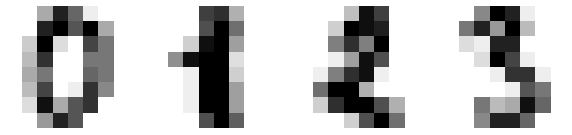

In [58]:
digits = datasets.load_digits()
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 4))
for ax, image in zip(axes, digits.images):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r,interpolation='nearest')

Each image is an 8 by 8 array of pixel values-- digitized hand-written digits. Larger number = darker. Max=16.

In [59]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

We can flatten it into a row of 64 column values (features) and try to build a model.

In [60]:
ddf=pd.DataFrame(digits.data,columns=digits.feature_names)

In [61]:
y=pd.DataFrame(digits.target,columns=['Target'])

In [62]:
ddf.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


Column name is pixes_row_column

In [63]:
y.head()

,Target
0,0
1,1
2,2
3,3
4,4


In [64]:
ddf.shape

(1797, 64)

In [65]:
y.shape

(1797, 1)

This could be a 10 class classification problem but we'll make it binary (and imbalanced).

In [66]:
def biny(x):
    if x==9:
        return 1
    else:
        return 0

In [67]:
by=y['Target'].apply(biny)

In [68]:
by[0:21]

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    1
20    0
Name: Target, dtype: int64

In [69]:
digits.images[19]

array([[ 0.,  0.,  6., 14.,  4.,  0.,  0.,  0.],
       [ 0.,  0., 11., 16., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  8., 14., 16.,  2.,  0.,  0.],
       [ 0.,  0.,  1., 12., 12., 11.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 11.,  3.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  5., 11.,  0.],
       [ 0.,  0.,  1.,  4.,  4.,  7., 16.,  2.],
       [ 0.,  0.,  7., 16., 16., 13., 11.,  1.]])

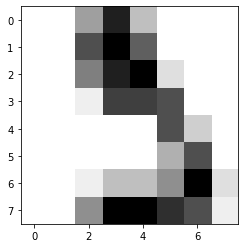

In [70]:
fig, ax = plt.subplots(figsize=(10,4))
ax.imshow(digits.images[19], cmap=plt.cm.gray_r,interpolation='nearest')
plt.show()

In [71]:
by.sum()/len(by)

0.1001669449081803

Train-Test split

In [72]:
Xd_train, Xd_test, yd_train, yd_test = train_test_split(ddf,by,random_state=0)

In [73]:
yd_test.shape

(450,)

Reminder that accuracy won't help:

In [74]:
ddum=DummyClassifier(strategy='most_frequent').fit(Xd_train,yd_train)

In [75]:
ddum.score(Xd_test,yd_test)

0.8955555555555555

In [76]:
f1_score(yd_test,ddum.predict(Xd_test))

0.0

In [77]:
dlr=LogisticRegression().fit(Xd_train,yd_train)

/home/hamstersnail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(This error goes away if we scale the data)

In [78]:
from sklearn.preprocessing import StandardScaler

In [79]:
scaler = StandardScaler()
Xd_train_scaled = scaler.fit_transform(Xd_train)
Xd_test_scaled = scaler.fit_transform(Xd_test)

In [80]:
scaled_dlr=LogisticRegression().fit(Xd_train_scaled,yd_train)

Simple decision tree classifier:

In [81]:
dclf=DecisionTreeClassifier(max_depth=4).fit(Xd_train,yd_train)

In [82]:
dclf.score(Xd_test,yd_test)

0.9466666666666667

In [83]:
dlr.score(Xd_test,yd_test)

0.9755555555555555

In [84]:
scaled_dlr.score(Xd_test_scaled,yd_test)

0.9822222222222222

In [85]:
f1_score(yd_test,dlr.predict(Xd_test))

0.8791208791208791

In [86]:
f1_score(yd_test,scaled_dlr.predict(Xd_test_scaled))

0.9069767441860465

In [87]:
print(classification_report(yd_test,scaled_dlr.predict(Xd_test_scaled)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       403
           1       1.00      0.83      0.91        47

    accuracy                           0.98       450
   macro avg       0.99      0.91      0.95       450
weighted avg       0.98      0.98      0.98       450



In [88]:
pd.crosstab(yd_test,scaled_dlr.predict(Xd_test_scaled),colnames=["Predicted"])

Predicted,0,1
Target,,
0,403,0
1,8,39


Unscaled logistic regression:

In [89]:
pd.crosstab(yd_test,dlr.predict(Xd_test),colnames=['Predicted'])

Predicted,0,1
Target,,
0,399,4
1,7,40


Simple decision tree classifier:

In [90]:
f1_score(yd_test,dclf.predict(Xd_test))

0.7073170731707318

In [91]:
pd.crosstab(yd_test,dclf.predict(Xd_test))

col_0,0,1
Target,,
0,397,6
1,18,29


In [92]:
print(classification_report(yd_test,dclf.predict(Xd_test)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       403
           1       0.83      0.62      0.71        47

    accuracy                           0.95       450
   macro avg       0.89      0.80      0.84       450
weighted avg       0.94      0.95      0.94       450



Let's build a Random Forest:

In [93]:
digit_rf = RandomForestClassifier(n_estimators=400,max_features='sqrt',random_state=0).fit(Xd_train,yd_train)

In [94]:
print(classification_report(yd_test,digit_rf.predict(Xd_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       403
           1       1.00      0.74      0.85        47

    accuracy                           0.97       450
   macro avg       0.99      0.87      0.92       450
weighted avg       0.97      0.97      0.97       450



In [95]:
pd.crosstab(yd_test,digit_rf.predict(Xd_test))

col_0,0,1
Target,,
0,403,0
1,12,35


Boosting classifier:

In [96]:
digit_boost = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1,max_depth=2, random_state=0).fit(Xd_train, yd_train)

In [97]:
pd.crosstab(yd_test,digit_boost.predict(Xd_test))

col_0,0,1
Target,,
0,403,0
1,6,41


In [98]:
print(classification_report(yd_test,digit_boost.predict(Xd_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       403
           1       1.00      0.87      0.93        47

    accuracy                           0.99       450
   macro avg       0.99      0.94      0.96       450
weighted avg       0.99      0.99      0.99       450



Both (scaled) logistic regression and boosting did very well. Boosting is the best.

We can look at a few of the images we "missed" on.

In [99]:
misses=np.where(yd_test!=digit_boost.predict(Xd_test))[0]

In [100]:
misses

array([ 90, 115, 130, 211, 312, 429])

All of these were, in fact, 9s, but we predicted NOT.

In [101]:
yd_test.iloc[[90,115,130,211, 312, 429]]

1412    1
361     1
37      1
19      1
1582    1
1186    1
Name: Target, dtype: int64

In [102]:
digit_boost.predict(Xd_test)[[90,115,130,211, 312, 429]]

array([0, 0, 0, 0, 0, 0])

Let's look at 211:

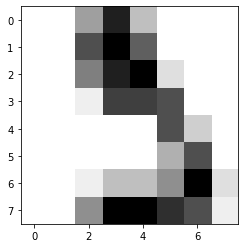

In [103]:
fig, ax = plt.subplots(figsize=(10,4))
ax.imshow(Xd_test.iloc[211].values.reshape(8,8), cmap=plt.cm.gray_r,interpolation='nearest')
plt.show()

Does that look nine-y?

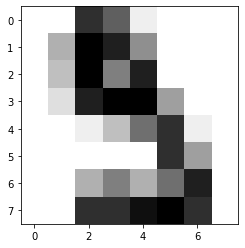

In [104]:
fig, ax = plt.subplots(figsize=(10,4))
ax.imshow(Xd_test.iloc[130].values.reshape(8,8), cmap=plt.cm.gray_r,interpolation='nearest')
plt.show()

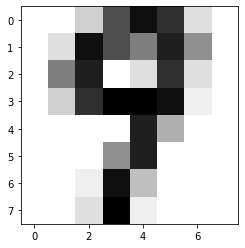

In [105]:
fig, ax = plt.subplots(figsize=(10,4))
ax.imshow(Xd_test.iloc[115].values.reshape(8,8), cmap=plt.cm.gray_r,interpolation='nearest')
plt.show()

### IMB learn

First, from the terminal run conda:

```conda install -c conda-forge imbalanced-learn```

```imblearn``` should be available in colab.

In [106]:
import imblearn

In [107]:
from imblearn.over_sampling import SMOTE

Let's go back to our original imbalanced toy data set:

In [108]:
toy.head()

,A,B,C,D,E,Target
0,-0.138680,0.537996,0.030868,-0.749413,-1.255079,0
1,1.153143,0.909027,-0.866711,-1.727731,-0.579336,0
2,1.609316,-1.935142,0.861705,0.349423,-1.135398,0
3,1.176314,1.524320,-0.137904,0.816670,0.663997,0
4,-0.245852,-0.158138,1.167393,-1.378489,0.679757,0


In [109]:
print(toy.shape,toy['Target'].sum()/len(toy))

(1000, 6) 0.117


In [110]:
oversample = SMOTE()
Xs, ys = oversample.fit_resample(X_train, y_train)

In [111]:
np.sum(ys)/len(ys)

0.5

Smote creates synthetic positive class observations to make classes balanced. It uses a *knn* approach: Create a new observation on the line between $x$ and one of its 3 nearest neighbors.

In [112]:
print(X_train.shape, Xs.shape)

(700, 5) (1238, 5)


In [113]:
rfs = RandomForestClassifier(n_estimators=400,max_features='sqrt',random_state=0).fit(Xs,ys)

In [114]:
f1_score(y_test,rfs.predict(X_test))

0.55

In [115]:
bs_clf = GradientBoostingClassifier(n_estimators=600,max_depth=3,learning_rate=0.1,random_state=0).fit(Xs,ys)

In [116]:
f1_score(y_test,bs_clf.predict(X_test))

0.5945945945945946

Considerable improvement

In [117]:
pd.crosstab(y_test,bs_clf.predict(X_test))

col_0,0,1
Target,,
0,248,16
1,14,22


In [118]:
print(classification_report(y_test,bs_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       264
           1       0.58      0.61      0.59        36

    accuracy                           0.90       300
   macro avg       0.76      0.78      0.77       300
weighted avg       0.90      0.90      0.90       300



In [119]:
bs_clf_no_os = GradientBoostingClassifier(n_estimators=600,max_depth=3,learning_rate=0.1,random_state=0).fit(X_train,y_train)

In [120]:
f1_score(y_test,bs_clf_no_os.predict(X_test))

0.5806451612903226

Oversampling gave improvement over a similar model w/o OS.

In [121]:
pd.crosstab(y_test,bs_clf_no_os.predict(X_test))

col_0,0,1
Target,,
0,256,8
1,18,18


In [122]:
print(classification_report(y_test,bs_clf_no_os.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       264
           1       0.69      0.50      0.58        36

    accuracy                           0.91       300
   macro avg       0.81      0.73      0.77       300
weighted avg       0.91      0.91      0.91       300



### A real dataset with serious class imbalance

Kinda big too so proceed with caution...

In [123]:
cc=pd.read_csv('creditcard.csv')

In [124]:
cc.shape

(284807, 31)

In [125]:
cc.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [126]:
cc.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [127]:
cc.Class.sum()

492

In [128]:
cc.Class.sum()/cc.shape[0]

0.001727485630620034

In [129]:
np.round(cc.describe(),2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [130]:
Xc=cc.drop('Class',axis=1)
yc=cc['Class']

In [131]:
Xc=Xc.drop('Time',axis=1)

In [132]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc,yc,test_size=0.4, random_state=10)

In [133]:
yc_test.sum()

190

In [134]:
yc_train.sum()

302

In [135]:
#num_trees=[10,20]

In [136]:
Xc_train.shape

(170884, 29)

In [137]:
scaler=StandardScaler()
Xc_train_scaled=scaler.fit_transform(Xc_train)
Xc_test_scaled=scaler.fit_transform(Xc_test)

In [138]:
lrc=LogisticRegression().fit(Xc_train_scaled,yc_train)

In [139]:
f1_score(yc_test,lrc.predict(Xc_test_scaled))

0.7416413373860182

In [140]:
unsc_lrc=LogisticRegression().fit(Xc_train,yc_train)

/home/hamstersnail/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [141]:
dtc=DecisionTreeClassifier(max_depth=4,random_state=0).fit(Xc_train,yc_train)

In [142]:
f1_score(yc_test,dtc.predict(Xc_test))

0.7954545454545454

In [143]:
dtcbig=DecisionTreeClassifier(random_state=0).fit(Xc_train,yc_train)

In [144]:
f1_score(yc_test,dtcbig.predict(Xc_test))

0.7917737789203085

In [145]:
##### Warning: Below takes crazy long! Be careful!!!
#If you did want to validate some paraeter choices like number of trees or max-depth etc.

```tqdm``` around the iterator will give a progress bar to show progress through the loop.

In [146]:
#from tqdm import tqdm
#cvres=[]
#for num in tqdm(num_trees):
#    rf_cv_clf = RandomForestClassifier(n_estimators = num, max_features='sqrt',max_depth=4,random_state=0)
#    cvclf = cross_validate(rf_cv_clf, Xc_train, yc_train, cv=5, scoring='f1')
#    cvres.append(cvclf['test_score'].mean())

In [147]:
rfc=RandomForestClassifier(n_estimators = 150, max_features='sqrt',max_depth=4,random_state=0).fit(Xc_train,yc_train)

In [148]:
f1_score(yc_test,rfc.predict(Xc_test))

0.81437125748503

In [149]:
print(classification_report(yc_test,rfc.predict(Xc_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113733
           1       0.94      0.72      0.81       190

    accuracy                           1.00    113923
   macro avg       0.97      0.86      0.91    113923
weighted avg       1.00      1.00      1.00    113923



* FP: we say FRAUD and it's not 
* FN: we say NO FRAUD and it is fraud

In [150]:
pd.crosstab(yc_test,rfc.predict(Xc_test),colnames=["Prediction"])

Prediction,0,1
Class,,
0,113725,8
1,54,136


Possible that we'd prefer to identify a few more of the False Negatives.

In [151]:
new_rfc_pred = rfc.predict_proba(Xc_test)[:,1] > .25

In [152]:
pd.crosstab(yc_test,new_rfc_pred,colnames=["Predicted"])

Predicted,False,True
Class,,
0,113709,24
1,35,155


In [153]:
f1_score(yc_test,new_rfc_pred)

0.8401084010840109

That actually *improved* the f1 score.

We can look at the performance of the classifier for various values of the prediction threshold all at once using precision recall curves.

In [154]:
from sklearn.metrics import precision_recall_curve

In [155]:
precision, recall, thresholds = precision_recall_curve(yc_test,rfc.predict_proba(Xc_test)[:,1])

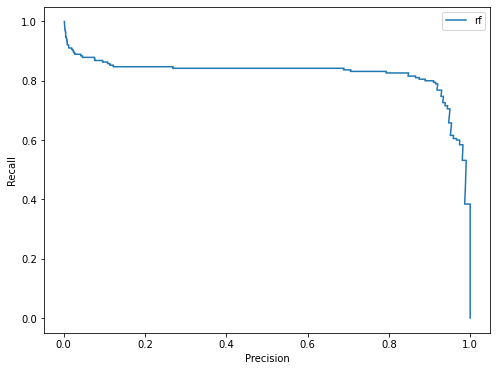

In [156]:
plt.figure(figsize=(8,6))
plt.plot(precision,recall,label='rf')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(['rf'],loc='best')
plt.show()

Each point on the curve gives Precision and Recall for a particular threshold value.

One way to get high Recall (identify lots of true 1s) is to predict lots of 1s. 

What's wrong with that? Lot's of false positives, i.e., low precision.

In [157]:
max(thresholds)

0.9533936770868164

Let's pick a threshold close to 0.5:

In [158]:
pt=np.argmin(np.abs(thresholds-0.5))

In [159]:
print(pt,":",thresholds[pt])

9929 : 0.49784610852430755


P and R at that point:

In [160]:
print(np.round(precision[pt],3),np.round(recall[pt],3))

0.938 0.716


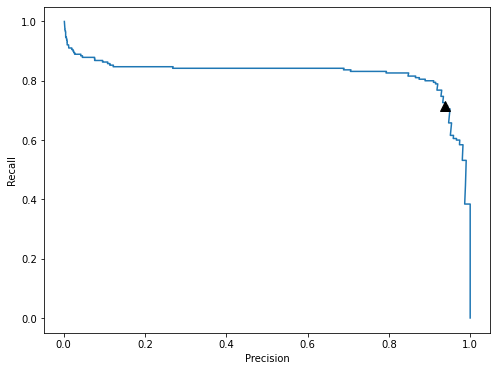

In [161]:
plt.figure(figsize=(8,6))
plt.plot(precision,recall,label='rf')
plt.plot(precision[pt],recall[pt],'^',c='k',markersize=10)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

Let's choose a lower threshold... so make it easier to predict Class = 1

What would we expect in terms of FP, FN?

In [162]:
newpt=np.argmin(np.abs(thresholds-0.25))

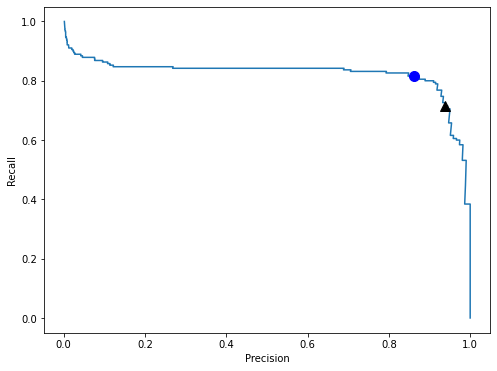

In [163]:
plt.figure(figsize=(8,6))
plt.plot(precision,recall,label='rf')
plt.plot(precision[pt],recall[pt],'^',c='k',markersize=10)
plt.plot(precision[newpt],recall[newpt],'o',c='b',markersize=10)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

In [164]:
print(np.round(precision[newpt],3),":",np.round(recall[newpt],3))

0.861 : 0.816


In [165]:
from scipy.stats import hmean

In [166]:
hmean([precision[newpt],recall[newpt]])

0.8378378378378379

In [167]:
hmean([precision[pt],recall[pt]])

0.8119402985074627

The ROC curve is another window into (basically) the same idea. It plots Recall against the FP rate.

In [168]:
from sklearn.metrics import roc_curve

In [169]:
fpr, tpr, thresholds = roc_curve(yc_test,rfc.predict_proba(Xc_test)[:,1])

In [170]:
pt=np.argmin(np.abs(thresholds-0.5))
newpt=np.argmin(np.abs(thresholds-0.25))
thirdpt=np.argmin(np.abs(thresholds-0.0001))

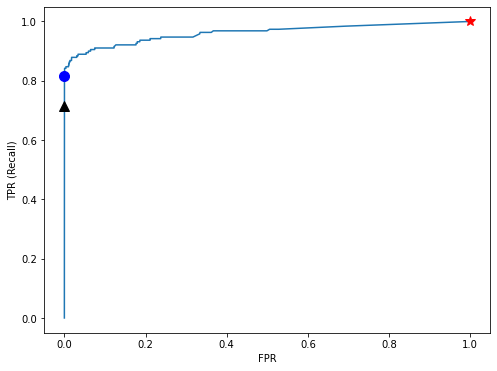

In [171]:
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,label='rf')
plt.plot(fpr[pt],tpr[pt],'^',c='k',markersize=10)
plt.plot(fpr[newpt],tpr[newpt],'o',c='b',markersize=10)
plt.plot(fpr[thirdpt],tpr[thirdpt],'*',c='r',markersize=10)
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.show()

As we increase Recall (our ability to identify true 1s we pay the price of more FP)

An overall metric of teh quality of the classifier is Area Under the ROC Curve (AUC). A good classifier will have a ROC curve that stays close to the y-axis and have high recall without increasing the FP rate (much)... so AUC close to 1.

In [172]:
from sklearn.metrics import average_precision_score, roc_auc_score

In [173]:
roc_auc_score(yc_test,rfc.predict_proba(Xc_test)[:,1])

0.9618710164665443

Avg precision score: Avg Precision at each threshold, weighted by increase in Recall over previous threshold

In [174]:
average_precision_score(yc_test,rfc.predict_proba(Xc_test)[:,1])

0.8255035363400172

Compare RF to LR

In [175]:
lrfpr, lrtpr, lrthresholds = roc_curve(yc_test,lrc.predict_proba(Xc_test_scaled)[:,1])

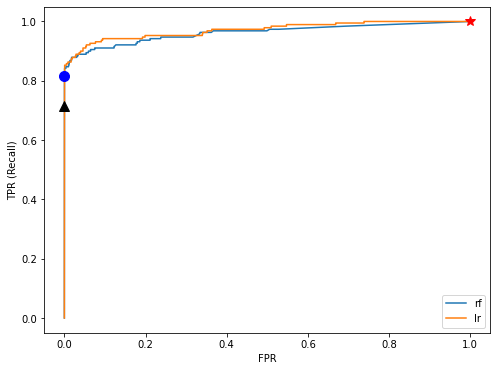

In [176]:
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,label='rf')
plt.plot(lrfpr,lrtpr,label='lr')
plt.plot(fpr[pt],tpr[pt],'^',c='k',markersize=10)
plt.plot(fpr[newpt],tpr[newpt],'o',c='b',markersize=10)
plt.plot(fpr[thirdpt],tpr[thirdpt],'*',c='r',markersize=10)
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.legend(['rf','lr'],loc='best')
plt.show()

In [177]:
lr_precision, lr_recall, thresholds = precision_recall_curve(yc_test,lrc.predict_proba(Xc_test_scaled)[:,1])

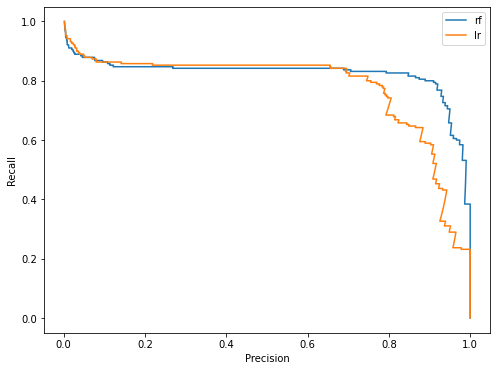

In [178]:
plt.figure(figsize=(8,6))
plt.plot(precision,recall,label='rf')
plt.plot(lr_precision,lr_recall,label='lr')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc='best')
plt.show()

## Sandbox

##### CreditCard dataset:

In [179]:
cc.shape

(284807, 31)

* Try a boosting model and see how it does. Validation will take a long time so maybe try 150 trees, learning rate of 0.1, and max depth = 3.
* What seems to be an optimal threshold value to use in the scaled logistic regression model? How are you evaluating what optimal means?
* Also try knn and SMOTE on the credit card data.

Another (usually worse approach) is downsampling: Make cc smaller but keep all the 1s: (usually worse because we're throwing information away)

In [180]:
cc1=cc[cc['Class']==1]
cc0=cc[cc['Class']==0]

In [181]:
ccs=cc0.sample(frac=.1)

In [182]:
ccs.shape

(28432, 31)

In [183]:
new_cc=pd.concat([ccs,cc1])
new_cc.shape

(28924, 31)

In [184]:
new_cc['Class'].sum()/new_cc.shape[0]

0.017010095422486517

Class imbalance now closer to 1.7%

In [185]:
new_cc.reset_index(inplace=True,drop=True)

In [186]:
new_cc.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,30773.0,-0.084643,-0.000905,1.272910,-1.465050,-0.341235,-0.494910,0.627486,-0.220742,-1.539314,...,-0.211592,-0.821216,0.145252,-0.082159,-0.254765,-0.706874,-0.178000,-0.209897,70.85,0
1,161995.0,2.081031,0.159475,-1.135983,2.767781,0.631345,0.512447,-0.098117,-0.149047,-2.321689,...,-0.140958,0.083307,0.070067,0.008626,0.140534,0.147217,-0.013145,-0.041242,19.34,0
2,60421.0,-1.517813,-1.950068,0.402197,-1.371111,-0.202506,0.256994,1.327808,-0.031868,-1.187958,...,0.620232,1.113064,1.018127,-0.321339,-0.250448,-0.329206,0.081191,0.039529,436.14,0
3,28874.0,-0.536624,0.365208,1.317581,1.598203,0.331597,-0.438582,0.261165,0.121112,-0.155111,...,0.014179,0.219561,0.101240,0.415485,0.009187,-0.239574,0.304169,0.088986,35.00,0
4,19948.0,1.084680,0.218006,0.985756,1.299543,-0.297970,0.227297,-0.433789,0.087603,1.175697,...,0.078948,0.515917,-0.076230,-0.021615,0.416808,-0.310723,0.029299,0.016071,24.00,0


#### Digits

Above we treated the digits data as a binary classification problem: 9 or Other. Now try leaving it as a full 10 Class problem. That is, try to correctly classify each digit as 0,1,2,3,4,5,6,7,8, or 9. Use logistic regression, random forest, boosting, knn. What does the classification report look like in thuis case? 

#### Another synthetioc dataset:

Play around with this and see how well you can do with classification.

In [187]:
from sklearn import datasets

In [188]:
X,y=datasets.make_classification(n_samples=1000, n_features=20, n_informative=7, n_redundant=5, n_classes=2, n_clusters_per_class=2, weights=[0.94,0.6], flip_y=0.07, class_sep=1.1, hypercube=False, shift=0.0, scale=1.0, shuffle=True, random_state=10)

In [189]:
fr=pd.DataFrame(X)

In [190]:
fr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2.868690,-0.106937,1.065444,0.749917,2.138981,-0.267874,-4.287288,-0.003229,0.102618,-1.594098,-1.920878,-0.031744,-1.836612,2.508588,2.123112,-1.599241,0.944821,0.330276,1.017247,-0.440207
1,-1.463642,-1.291157,-1.464761,1.287344,-1.994637,0.831797,0.130555,-0.555585,-1.746450,0.320191,1.112363,-0.948864,0.497305,2.651037,1.722998,0.290210,-1.278545,0.488835,1.577497,-1.097335
2,-2.208983,1.112905,1.484842,1.455104,-0.380712,-0.465900,3.464477,1.561576,-0.972615,2.646365,-0.463730,0.571619,-0.573899,-4.393691,-3.936344,5.499447,0.874778,-0.858103,-1.040617,-2.759917
3,1.757493,-0.194035,-1.502209,-1.227620,-1.629453,2.192913,-0.774430,-1.284792,0.433154,2.233775,-0.714185,0.089484,-2.290146,-2.274138,-3.454273,-0.904307,0.459121,-0.043155,-2.129675,-0.559314
4,-0.621503,-1.709654,-2.155096,-1.982270,-1.205284,-0.285097,-1.279000,-3.831940,-1.205034,-4.213100,-0.121912,0.808936,0.647993,4.629954,3.860843,-1.288296,0.992935,1.069965,3.676966,1.005724


In [191]:
y[0:10]

array([0, 1, 0, 0, 0, 0, 1, 1, 1, 0])